In [293]:
# Import all necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import pgeocode #To preprocess ZIP code into county

# Personal Loans
An important source of income for banks comes from interest gathered from loans made to customers. As such, it is important to  grow the number of personal loans a bank gives since this results in a direct increase in profits.
In the past this used to be done by a person who would look at a person's file and conclude whether or not they should be offered a loan. Clearly, this would result in biased decisions and in many occasions, customers who were offered a loan would reject it. Moreover, the time spent by the bank clerk reviewing files would be considered a loss, money and resources wasted on unproductive activities. Nowadays, banks can leverage the large amounts of information they have on customers and use mathematical algorithms to predict loan acceptance probabilties. For this project, we will use two popular machine learning techniques, logistic regression and decision trees. As usual, we will take a look at our data, preprocess columns where required and feed this information into our models. Before we can do all this, we must take a look at univariate and bivariate plots to help us understand the distribution of our dataset and the relationship between variables. Lets start with some exploratory data analysis and precprocessing technqiues!

# EDA - Data Preprocessing

In [294]:
# Load data set
df = pd.read_csv("Loan_Modelling.csv")

In [295]:
df['Income'].mean()

73.7742

In [296]:
# Random sample with seed set to 10 for results reproduction
np.random.seed(1)
df.sample(n=15)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
2764,2765,31,5,84,91320,1,2.90,3,105,0,0,0,0,1
4767,4768,35,9,45,90639,3,0.90,1,101,0,1,0,0,0
3814,3815,34,9,35,94304,3,1.30,1,0,0,0,0,0,0
3499,3500,49,23,114,94550,1,0.30,1,286,0,0,0,1,0
2735,2736,36,12,70,92131,3,2.60,2,165,0,0,0,1,0
3922,3923,31,4,20,95616,4,1.50,2,0,0,0,0,1,0
2701,2702,50,26,55,94305,1,1.60,2,0,0,0,0,1,0
1179,1180,36,11,98,90291,3,1.20,3,0,0,1,0,0,1
932,933,51,27,112,94720,3,1.80,2,0,0,1,1,1,1
792,793,41,16,98,93117,1,4.00,3,0,0,0,0,0,1


In [297]:
# Print preliminary information about dataset such as dimensions, types of variables, 5-point statistics and null values.
# We can safely drop ID and reset our Dataframe index
df.drop(columns='ID', inplace=True)
df.reset_index(drop=True, inplace=True)
print('Types of variables in dataframe:')
print(df.info())
print('\nShape of dataframe:')
print(df.shape)
print('\n5 Point analysis of numerical variables in dataframe:')
print(df.describe())
print('\nNumber of null values in dataframe:')
print(df.isnull().sum())

Types of variables in dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB
None

Shape of dataframe:
(5000, 13)

5 Point analysis of numerical vari

From our preliminary exploration, we see that there are 5000 rows and 13 columns, from which 'Personal_Loan' is the target varibale and what we want to predict with help of our models. All columns are numerical, but in reality, some of them should be categorical. We have both ordinal and nominal data types so we must preprocess those columns. There doesn't seem to be missing values but this needs further investigation. Minimum experience is negative which is not possible. We can either drop observations with negative values or turn them into 0. However, it might also be the case that the negative sign was put there by mistake, we can check income value and age, and if logical to assume it was a mistake, change to positive number. Let us first change variable types and look at their respective distribution.
- Most customers are between 35 and 55 years of age
- Most customers do not have a mortgage on their house, the mean debt is 101, 000 dollars
- Income is highly skewed, visualization should help us see the distribution better
- Maximum family size is 4 and minimum is 1

# Categorical Variable Analysis

1    29.44
2    25.92
4    24.44
3    20.20
Name: Family, dtype: float64
1    41.92
3    30.02
2    28.06
Name: Education, dtype: float64
0    90.4
1     9.6
Name: Personal_Loan, dtype: float64
0    89.56
1    10.44
Name: Securities_Account, dtype: float64
0    93.96
1     6.04
Name: CD_Account, dtype: float64
1    59.68
0    40.32
Name: Online, dtype: float64
0    70.6
1    29.4
Name: CreditCard, dtype: float64


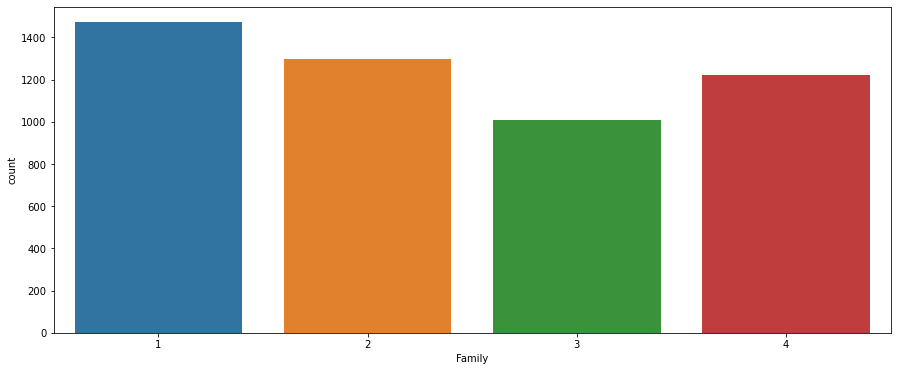

<Figure size 432x288 with 0 Axes>

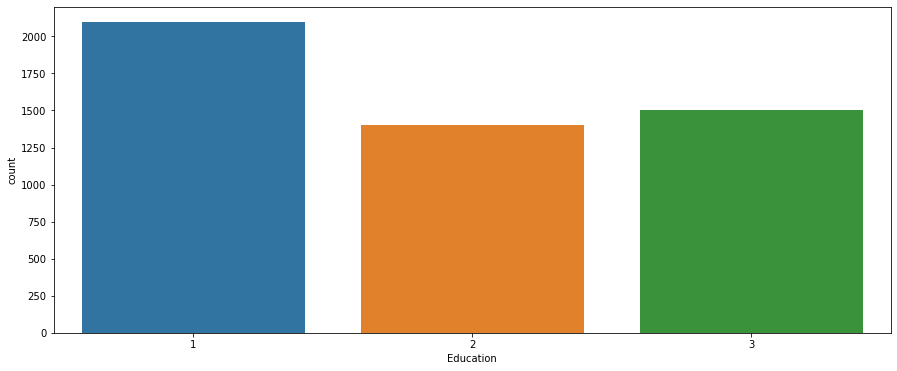

<Figure size 432x288 with 0 Axes>

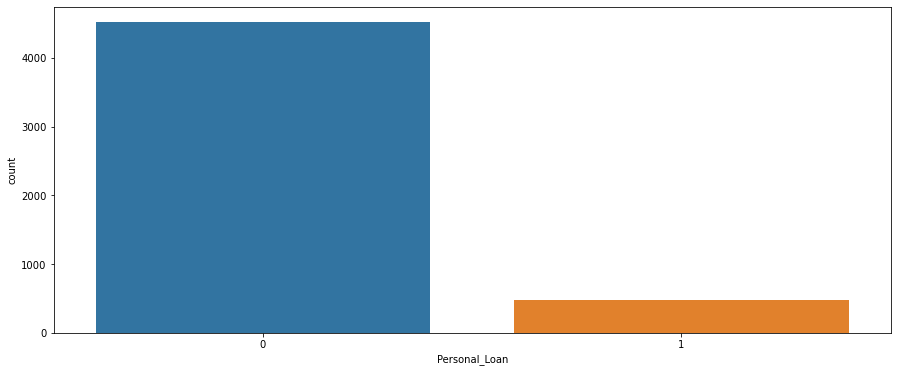

<Figure size 432x288 with 0 Axes>

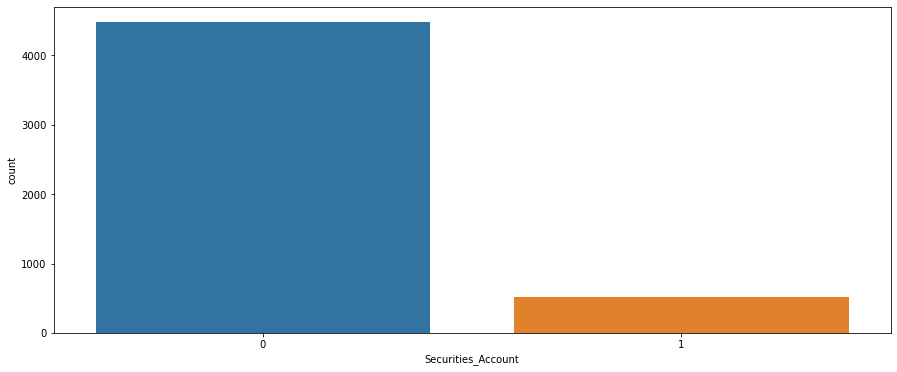

<Figure size 432x288 with 0 Axes>

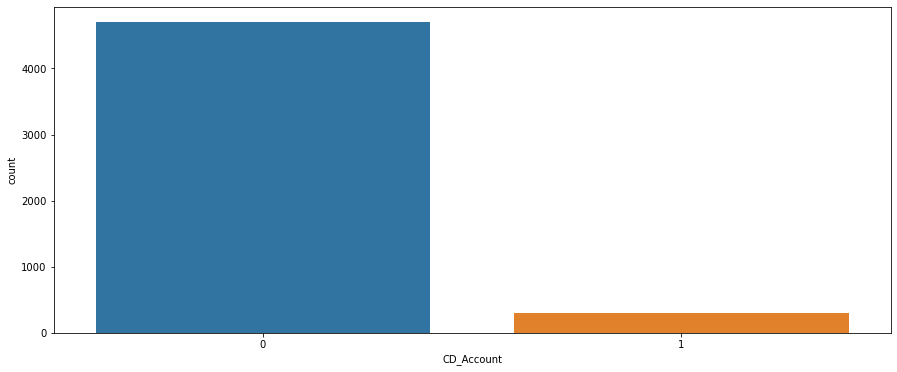

<Figure size 432x288 with 0 Axes>

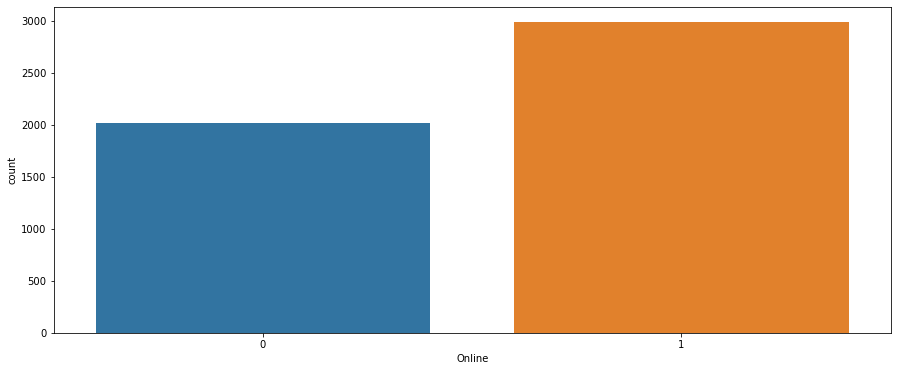

<Figure size 432x288 with 0 Axes>

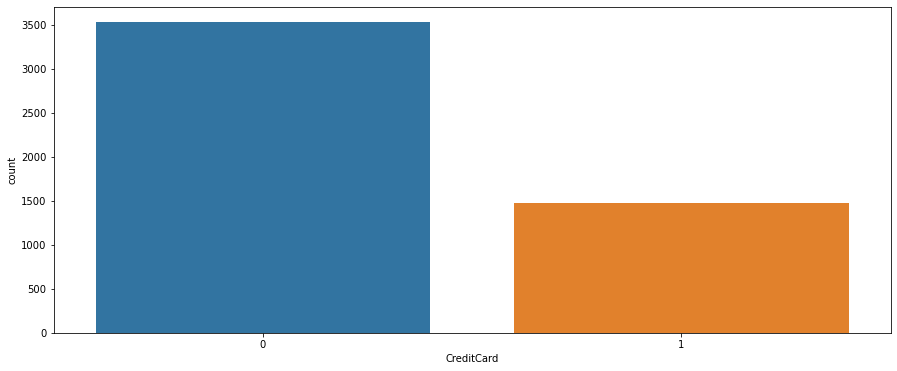

<Figure size 432x288 with 0 Axes>

In [298]:
# The columns we need to change are: ZIP code - which we will convert to county (in feature engineering section),
#Education - which we will convert to, categorical ordinal and Family, Securities_Account, CD_Account, 
#Online and CreditCard which we will convert into dummies after visualizing them

    
for i in ['Education', 'Personal_Loan','Family', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']:
    df[i]= df[i].astype('category')

for i in df.columns[df.dtypes == 'category']:
    plt.figure(figsize=(15,6))
    sns.countplot(df[i])
    print(df[i].value_counts(normalize=True)*100) # To see percentage composition
    plt.figure()


- Almost 30 per cent of all customers are sole individuals in their household, but there seems to be a relatively balanced size, 1, 2, 3 and 4 family members being 25 per cent each more or less.
- 41 per cent of al, customes hold and undergrad degree, 30 per cent are graduate level and 28 per cent hold advanced degrees
- We notice 89.56 per cent of customers who were offered a loan declined, so our model has to beat 89.56 per cent accuracy or it will be worse than just predicting No for every observation
- Only 6 per cent of clients have securities investment accounts with the bank
- Similarly, only 1/3 of cutomers have an online account in use

In [299]:
# Let's take a deeper look at observations with negative Experience values
df[df['Experience'] < 0]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,25,-1,113,94303,4,2.30,3,0,0,0,0,0,1
226,24,-1,39,94085,2,1.70,2,0,0,0,0,0,0
315,24,-2,51,90630,3,0.30,3,0,0,0,0,1,0
451,28,-2,48,94132,2,1.75,3,89,0,0,0,1,0
524,24,-1,75,93014,4,0.20,1,0,0,0,0,1,0
536,25,-1,43,92173,3,2.40,2,176,0,0,0,1,0
540,25,-1,109,94010,4,2.30,3,314,0,0,0,1,0
576,25,-1,48,92870,3,0.30,3,0,0,0,0,0,1
583,24,-1,38,95045,2,1.70,2,0,0,0,0,1,0
597,24,-2,125,92835,2,7.20,1,0,0,1,0,0,1


From our slice above, we notice all individuals are under 30 years of age but do have and income. We will assume this was an entry mistake and turn them into positive values

In [300]:
# Take absolute value to avoid negative numbers
df['Experience'] = abs(df['Experience'])

# Univariate Analysis - Outlier Detection

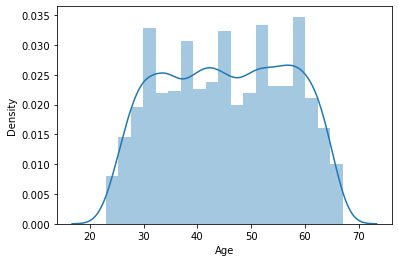

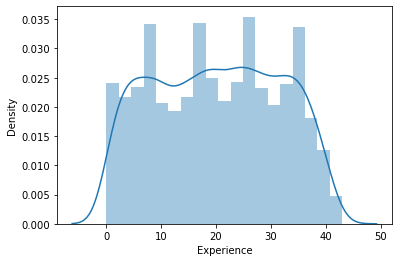

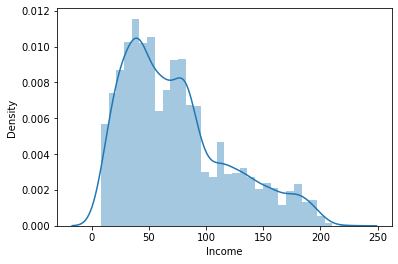

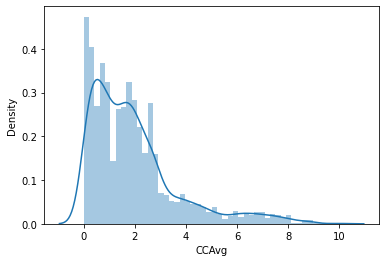

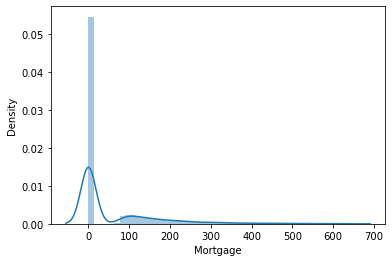

<Figure size 432x288 with 0 Axes>

In [301]:
# Let us now look at a boxplot and histogram for our numerical values
df['ZIPCode']= df['ZIPCode'].astype('category') # Since we don't want to plot a histogram for ZIP codes
for i in df.select_dtypes([np.number]).columns:
    sns.distplot(df[i]);
    plt.figure()

As we can see, Income, CCAvg and Mortgage are highly skewed. We will fix that in the next step by applying a log tranformation. Notice Experience and Age distribution ressembles a uniform distribution (although not exactly of course). However, I can tell this will make it difficult to find a correlation between those variables and the others, perhaps the pairplot will prove this point!

In [302]:
# Substitute Income, CCAvg and Mortgage columns with the log of the respective columns
for i in ['Income', 'CCAvg', 'Mortgage']:
    df[i]=np.log(df[i])

Number of individuals wihtout mortgage on their house:


3462

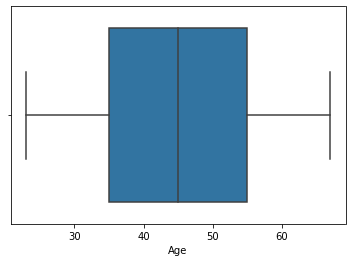

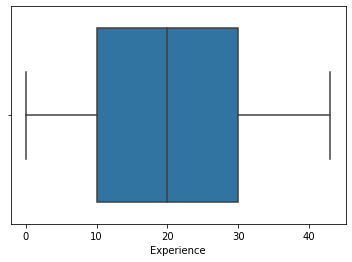

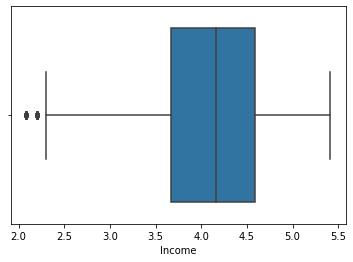

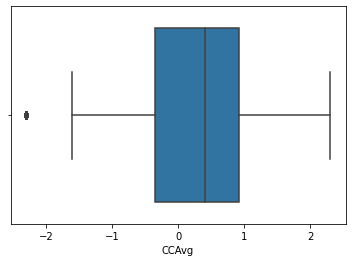

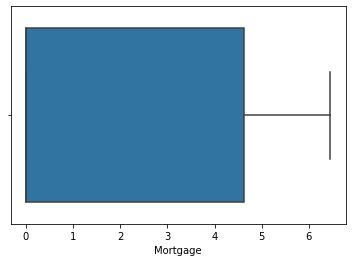

<Figure size 432x288 with 0 Axes>

In [303]:
# Taking the log of zero will result in -inf according to documentation so we have to change that back to zero
df.replace(np.NINF, 0, inplace=True)
for i in df.select_dtypes([np.number]).columns:
    sns.boxplot(df[i]);
    plt.figure()
print('Number of individuals wihtout mortgage on their house:')
df[df['Mortgage'] == 0].value_counts().sum()

In [304]:
df = df[df['CCAvg'] > -2.3]  
df = df[df['Income'] > 2.3]

We seem to have values with negative average credit card spending which might seem problematic at first, but it means the individual made more payments that withdrawals on their card. All other independent variables look about right after applying the log transformatio and replacing -inf with 0. Most people in the dataset do not have a mortgage which is the reason the boxplot looks like this. There seems to be an outlier on CCAvg but we cannot assume this is an error, it is possible the person in question wanted to get rid of his credit card debt in a fastly manner. We have some outliers in income as well. Since logistic regression is very easily affected by outliers, we will drop these 3 observations.

# Feature Engineering

In [305]:
# We will use the Zip code to convert it into a county which we can then turn into a dummy variable
def zip_to_county(x): #Function which returns County from ZIP code
    zp = pgeocode.Nominatim('US')
    return(zp.query_postal_code(np.array(x.astype('string'))))
    
df['County']= zip_to_county(df['ZIPCode'])['county_name'].astype('category')
df.drop(columns='ZIPCode', inplace=True)

df['County'].value_counts().head(10)

# Thanks to the visualization above and the count of people without a mortgage, we know that almost 3500 individuals do
# not a have a loan with their house as collateral. For this reason, we will change the column 'Mortgage' into a dummy
# variable instead of a continous one.
df['Mortgage'] = np.where(df['Mortgage'] > 0, 1, 0)
df['Mortgage'] = df['Mortgage'].astype('category')


Once we have turned Zip codes into counties we can see Los Angeles, San Diego, Santa Clara and Alameda account for more than 50 per cent of our examples. This makes sense since those are also the most populated counties in California!

# Bivariate Analysis

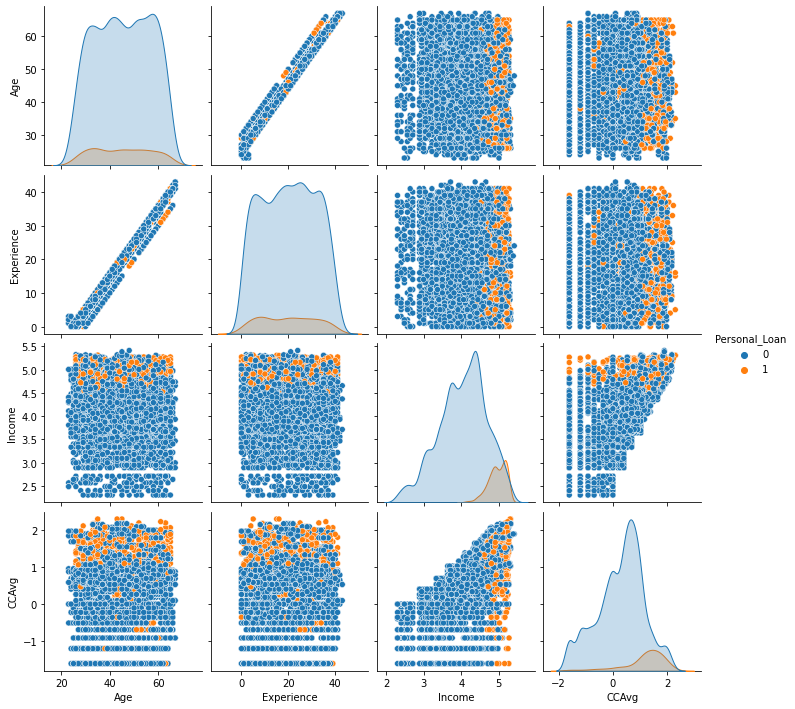

In [306]:
sns.pairplot(df, x_vars=['Age', 'Experience', 'Income', 'CCAvg'], y_vars=['Age', 'Experience', 'Income', 'CCAvg'],
             hue='Personal_Loan')

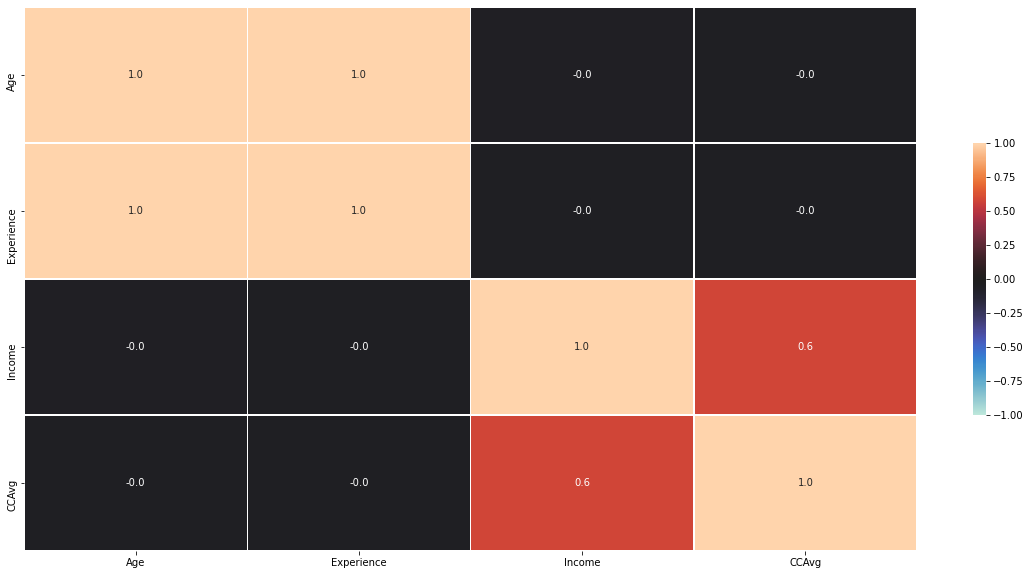

In [307]:
# Let's plot a heatmap of correlation between our numerical values to see if we can drop any of them
numeric_columns = df.select_dtypes(include=np.number).columns.tolist() # Select only numeric columns and drop Year
corr = df[numeric_columns].corr()

f, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(corr, annot=True,fmt=".1f",vmin=-1, vmax=1, center= 0, square=False, linewidths=.7, cbar_kws={"shrink": .5});

There is a clear 1 to 1 correlation between Age and Experience which makes complete logical sense. We will be dropping either column in the next part. There also seems to be a medium correlation between credit card spenditure and Income, which again, makes total sense since a higher income usually allows for larger expenditures. This correlation is not as strong as the first though, and we will not drop neither column since we would risk losing improtant information. Notice the shape of the histogram for Age, Experience and CCAvg resembles a uniform distribution, which is the reason we don't see any correlation, both visualy nor numerically, between variables.

In [308]:
# Before we drop highly correlated columns, we will encode our nominal categorical variables into dummy variables
df_dummies = pd.get_dummies(df, prefix=['Mortgage','Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'County'],
                            columns=['Mortgage','Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'County'], 
                            drop_first=True)

In [309]:
# Standarization of our numerical values so they have a close scale and do not affect our model
def z_transform(x):
    return (x - np.mean(x)) / np.std(x)

for i in ['Age', 'Experience', 'Income', 'CCAvg']:
    df_dummies[i] = z_transform(df_dummies[i])
df_dummies

,Age,Experience,Income,Family,CCAvg,Education,Personal_Loan,Mortgage_1,Securities_Account_1,CD_Account_1,Online_1,CreditCard_1,County_Butte,County_City and County of San Francisco,County_Contra Costa,County_El Dorado,County_Fresno,County_Humboldt,County_Imperial,County_Kern,County_Lake,County_Los Angeles,County_Marin,County_Mendocino,County_Merced,County_Monterey,County_Napa,County_Orange,County_Placer,County_Riverside,County_Sacramento,County_San Benito,County_San Bernardino,County_San Diego,County_San Joaquin,County_San Luis Obispo,County_San Mateo,County_Santa Barbara,County_Santa Clara,County_Santa Cruz,County_Shasta,County_Siskiyou,County_Solano,County_Sonoma,County_Stanislaus,County_Trinity,County_Tuolumne,County_Ventura,County_Yolo
0,-1.770683,-1.672733,-0.347206,4,0.121368,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.024082,-0.093139,-0.896331,3,0.048939,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.548062,-0.444160,-2.591916,1,-0.406102,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.897382,-0.970691,0.724644,1,0.708593,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.897382,-1.058446,-0.475161,4,-0.406102,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.421363,-1.497222,-0.652137,1,0.314230,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,-1.334033,-1.409467,-2.125890,4,-1.434426,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,1.547860,1.661965,-1.419682,2,-1.757282,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,1.722520,1.749721,-0.347206,3,-1.183999,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Logistic Regression - Preparing Data for this model

In [310]:
# We have to separate our independent and dependent variable, and add constant term to before we can perform VIF analysis
X = df_dummies.drop(columns='Personal_Loan')
y = df_dummies[['Personal_Loan']]
X_mc = X.copy()
X_mc['Constant'] = 1

# Filtering highly correlated independent variables

In [311]:
# We can now check for multicollinearity and drop columns that have a high value (more than 10)
vif = pd.Series([variance_inflation_factor(X_mc.values,i) for i in range(X_mc.shape[1])],index=X_mc.columns)
print(format(vif))

Age                                        88.303376
Experience                                 88.263142
Income                                      1.603402
Family                                      1.037049
CCAvg                                       1.527703
Education                                   1.112282
Mortgage_1                                  1.012219
Securities_Account_1                        1.143079
CD_Account_1                                1.321045
Online_1                                    1.046478
CreditCard_1                                1.119616
County_Butte                                1.022946
County_City and County of San Francisco     1.266712
County_Contra Costa                         1.098399
County_El Dorado                            1.022421
County_Fresno                               1.030872
County_Humboldt                             1.034303
County_Imperial                             1.006118
County_Kern                                 1.

Just as we suspected from our initial correlation heatmap, Age and Experience are highly correlated with each other and we must get rid of either column in order to avoid multicollinearity. The good news is that none of the other columns seem to be high correlated and are well below our threshold of 10 and even lower that 5!

# Test and Training set split

In [312]:
# We must now split our datasets into training and testing sets, respectively. We use sci-kit learn pre-built function for
# this
X.drop('Experience', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=25)

In [313]:
X_train.info() # To check our independent variables will be compatible with our models

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3343 entries, 344 to 330
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Age                                      3343 non-null   float64 
 1   Income                                   3343 non-null   float64 
 2   Family                                   3343 non-null   category
 3   CCAvg                                    3343 non-null   float64 
 4   Education                                3343 non-null   category
 5   Mortgage_1                               3343 non-null   uint8   
 6   Securities_Account_1                     3343 non-null   uint8   
 7   CD_Account_1                             3343 non-null   uint8   
 8   Online_1                                 3343 non-null   uint8   
 9   CreditCard_1                             3343 non-null   uint8   
 10  County_Butte                       

# Relationship between independent and dependent variables

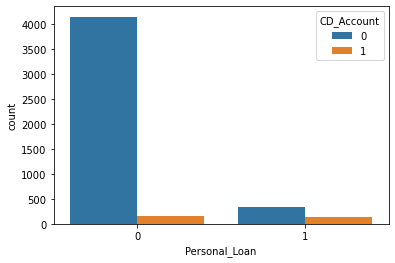

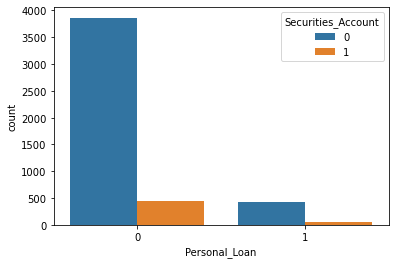

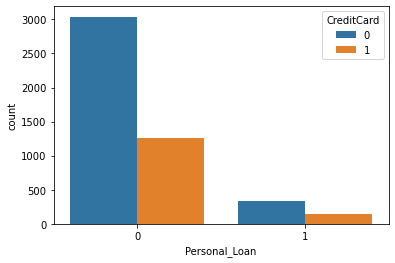

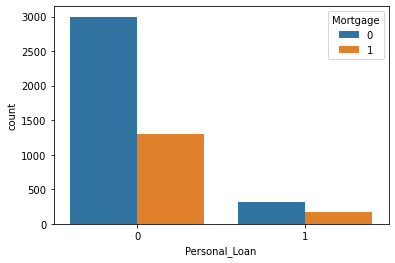

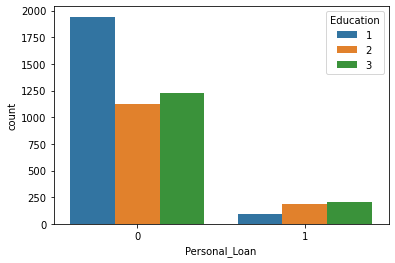

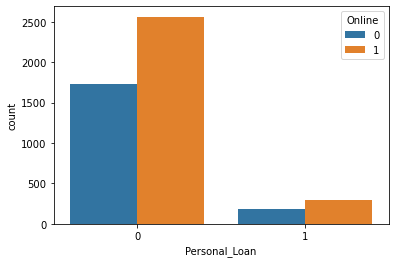

<Figure size 432x288 with 0 Axes>

In [314]:
# Lets look again at a count plot but use hue to detect any relationships between unbalanced classes such as CD_Account, 
# Securities Account or Credit Card and our target variable
for i in ['CD_Account', 'Securities_Account', 'CreditCard', 'Mortgage', 'Education', 'Online']:
    sns.countplot(x='Personal_Loan', hue=i, data=df)
    plt.figure()

In [315]:
for i in ['CD_Account', 'Securities_Account', 'CreditCard', 'Mortgage', 'Education', 'Online']:
    print(df.groupby('Personal_Loan')[i].value_counts(normalize=True)*100)

Personal_Loan  CD_Account
0              0             96.463471
               1              3.536529
1              0             70.920502
               1             29.079498
Name: CD_Account, dtype: float64
Personal_Loan  Securities_Account
0              0                     89.785947
               1                     10.214053
1              0                     87.447699
               1                     12.552301
Name: Securities_Account, dtype: float64
Personal_Loan  CreditCard
0              0             70.660772
               1             29.339228
1              0             70.292887
               1             29.707113
Name: CreditCard, dtype: float64
Personal_Loan  Mortgage
0              0           69.730107
               1           30.269893
1              0           64.853556
               1           35.146444
Name: Mortgage, dtype: float64
Personal_Loan  Education
0              1            45.160540
               3            28.594695
   

- Ratios for CD_Account, seem to be quite different, this variable will probably have large importance on our models. We will obtain more information once we have created our models. Notice that from people who accepted the loan, 43% per cent help a professional degree, Education may also play an important role in our models!
- Ratios for Credit Card holders,  Securities_Account, Online, and Mortgage are relatively similar. This doesn't mean varibales won't play an important part in our model but does mean that the odd log coefficient will be relatively smaller than for varibales with stronger difference between them.

In [316]:
# Let's now take a look at the relationship between Personal_Loan and numerical variables
for i in ['Age', 'Income', 'CCAvg']:
    print('\n', i)
    print(df.groupby('Personal_Loan')[i].mean())



 Age
Personal_Loan
0    45.293858
1    45.112971
Name: Age, dtype: float64

 Income
Personal_Loan
0    4.031111
1    4.948202
Name: Income, dtype: float64

 CCAvg
Personal_Loan
0    0.274606
1    1.146395
Name: CCAvg, dtype: float64


- Average age for those that accepted the loan and those that did not is almost exactly the same.
- Mean years of experience is also very similar
- Mean income for those that accepted the loan is more than double of those that declines. This variable will probably have a strong effect on the class probability.

In [317]:
# Initialize Model and fit to training data. We use Lasso penalty since it drives to zero the least important features
logr = LogisticRegression(penalty = 'l1', solver='liblinear')
logr.fit(X_train, y_train)
logr.score(X_train, y_train) # Accuracy is higher than 90 per cent so it's better than just guessing the most common class
# for all examples. We will now look at other important metrics such as precision and recall and plot a confusion matrix.
# Notice too that accuracy is simiar for both sets so our model is not overfitting the training data.

0.9509422674244691

In [318]:
logr.score(X_test, y_test)

0.9630146545708305

It is important to know which metric we actually want to maximize since there is a trade-off between Precision and Recall. If we assume the company would like to increase the number of customers that ask for a loan, then it is costly for the bank to not offer loans to people likely to accept it. That means we want to minimize the number of False Negative results, in other words, we want to maximize recall.

In [319]:
# We create a custom function to measure the performance of our models. Since we will also be applying a decision tree,
# this way we don't have to write the same code again and again! 

def metrics_func(model, X_train, X_test, y_train, y_test): # The function takes the model and then computes the performance 
    # measures on both train and test sets
    
    pred_train = model.predict(X_train) # makes predictions which we then pass to our performance measure functions
    pred_test = model.predict(X_test)
    
    train_acc = accuracy_score(pred_train,y_train)
    test_acc = accuracy_score(pred_test,y_test)
    
    train_recall = recall_score(y_train,pred_train)
    test_recall = recall_score(y_test,pred_test)
    
    train_precision = precision_score(y_train,pred_train)
    test_precision = precision_score(y_test,pred_test)
    
    # We use sci-kit pre made functions to print our results
    print("Accuracy on training set : ",accuracy_score(pred_train,y_train))
    print("Accuracy on test set : ",accuracy_score(pred_test,y_test))
    print("Recall on training set : ",recall_score(y_train,pred_train))
    print("Recall on test set : ",recall_score(y_test,pred_test))
    print("Precision on training set : ",precision_score(y_train,pred_train))
    print("Precision on test set : ",precision_score(y_test,pred_test))

# We also need a function that creates a confusion matrix so we can visualize the performance of our model and compare the
# vanilla version with the improved versions, as well as comparing algorithm perfomances (logistic regression - tree)
def confusion_matrix(model, X, y, labels=[1, 0]):
    
    y_predict = model.predict(X)
    cm=metrics.confusion_matrix( y, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]], # show labels
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in # format how many zeroes to show
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in # show underneath count the percentage value
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)] # zip function to make tuples of number of values and respective %
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [320]:
metrics_func(logr, X_train, X_test, y_train, y_test)

Accuracy on training set :  0.9509422674244691
Accuracy on test set :  0.9630146545708305
Recall on training set :  0.638235294117647
Recall on test set :  0.6811594202898551
Precision on training set :  0.8410852713178295
Precision on test set :  0.912621359223301


We see our precision is relatively high on both train and test sets but not great on recall on either set. We will have to move the threshold around to improve recall. This also means precision will fall, but the bank should be comfortable offering some more loans to those that won't take it instead of not offering to those likely to accept it!

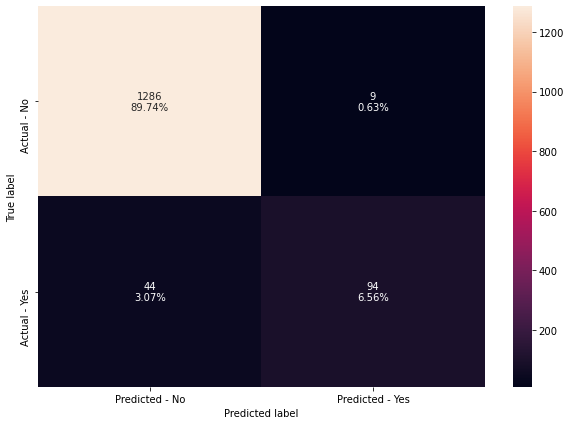

In [321]:
confusion_matrix(logr, X_test, y_test)

This visualization reiterates what we found with our performance function, only 15 false positives but 56 false negatives. We must fix this!

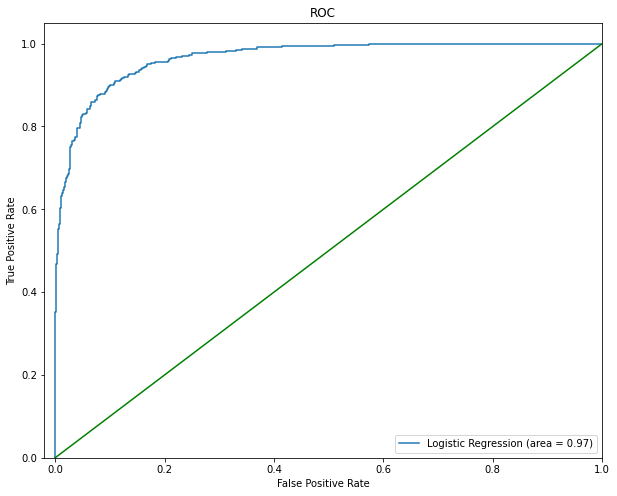

In [322]:
# We will now plot a ROC graph to see how well our model performs compared to randomly guessing 
logit_roc_auc_train = roc_auc_score(y_train, logr.predict_proba(X_train)[:,1]) # takes all rows and second column
fpr, tpr, thresholds = roc_curve(y_train, logr.predict_proba(X_train)[:,1]) # plots TP and FP values
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train) # two significant figures in number
plt.plot([0, 1], [0, 1],'g') # Plot diagonal in graph, we want our curve to be the farthest away from it as possible
plt.xlim([-.02, 1.0]) # limits for how much extra padding we want in graph
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Our model does well compared to only guessing labels, of course since our labels are quite unbalanced this is to be expected, so we must consider both the ROC and performance measures together when assesing our model

In [323]:
log_odds = logr.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)

,coef
Income,4.203841
CD_Account_1,3.510035
Education,1.618539
County_San Bernardino,0.861665
Family,0.658203
County_Ventura,0.415468
CCAvg,0.332905
County_Los Angeles,0.266974
County_Santa Clara,0.160873
Mortgage_1,0.119635


# Coefficient Interpretation

As we had predicted at the beginning of our Exploratory Analysis, both Income and Certificate of Deposit account dummy play an important role as predictors of our model. This just comes to show how important it is to analyse visualizations and try to find patterns. By doing so, we are able to better understand our model. We also note that having a credit card is associated with a decrese in the probability of accepting a loan. Again, makes logical sense since individuals in debt would not like to further inccur in a larger one. Individuals with a securities account might be less probable to accept loan since they already have a large income.
Notice too, that since we decided to use l1 regularization, most of our coefficients have been driven to zero. This is a kind of implicit principal component analysis and helps improve training efficiency (although with such as small dataset it doesn't really make an impact).

# Model Improvement

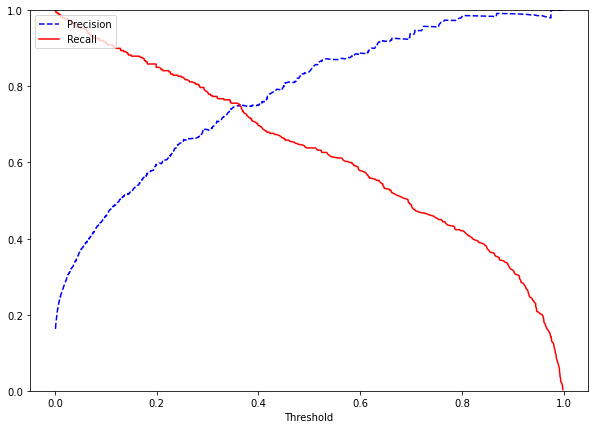

In [324]:
# In order to select a threshold that maximizes recall, we can plot the recall and precision curves for each threshold
# from 0 to 1 and select the appropriate number. Notice that we could easily select a threshold very close to 0 and get
# almost perfect recall, but a model with precision 0 would not be very useful!
y_scores=logr.predict_proba(X_train)[:,1] # get all rows and second column
prec, rec, thre = precision_recall_curve(y_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision') #plots precision curve on slash blue line
    plt.plot(thresholds, recalls[:-1], 'r', label = 'Recall') # plots recall curve on full red since it's the measure we
    plt.xlabel('Threshold')                                   # want to maximaize as we explained previously
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, thre)
plt.show()

In [325]:
pred_train_opt = (logr.predict_proba(X_train)[:,1]>.30)
pred_test_opt = (logr.predict_proba(X_test)[:,1]>.30)

In [326]:
print('Accuracy on train data:',accuracy_score(y_train, pred_train_opt) )
print('Accuracy on test data:',accuracy_score(y_test, pred_test_opt))

print('Recall on train data:',recall_score(y_train, pred_train_opt))
print('Recall on test data:',recall_score(y_test, pred_test_opt))

print('Precision on train data:',precision_score(y_train, pred_train_opt) )
print('Precision on test data:',precision_score(y_test, pred_test_opt))

print('ROC-AUC Score on train data:',roc_auc_score(y_train, pred_train_opt) )
print('ROC-AUC Score on test data:',roc_auc_score(y_test, pred_test_opt))

Accuracy on train data: 0.9413700269219264
Accuracy on test data: 0.9574319609211445
Recall on train data: 0.7823529411764706
Recall on test data: 0.8333333333333334
Precision on train data: 0.6855670103092784
Precision on test data: 0.7516339869281046
ROC-AUC Score on train data: 0.870863450275215
ROC-AUC Score on test data: 0.9019948519948521


The first thing to notice is that our model generalizes well. The values for Accuracy, Recall and Precision are similar for our training and test set, which means the models does not capture too much noise and does not overfit. This is important if we want to use our model in the real world with unseen data. Secondly, we have been able to increase recall from 68 to 83, a 20 per cent improvement over model with threshold of .5. Not only that, but we were able to keep precision at an acceptable level of 75 per cent as well! In other words, we increased Recall by 20 per cent, lowered precision by 10 per cent whoch resulted in a 10 per cent net gain.

# Recommendations (Based off Logistic Regression)
- Income is a very good indicator of whether an individual will accept or decline a loan, the bank should focus their marketing efforts towards individuals with high incomes.
- Customers with a certificate of deposit account are more likely to accept loans, this was noted by both the importnace of its coefficient and the visualization at the beginning of the project.
- Highly educated individuals, are also more likely to take the loan, the bank shoudl marjet towards master's and professional degree holders.
- On the other side of the spectrum, individuals who hold a credit card with the bank are less likely to take the loan, perhaps this is due to the fact that the CD itself is a type of loan.
- Having and online bank account also seems to be negatively associated with probability of accepting said loan, this might make marketing campaign more difficult since the client will have to be contacted through other mediums such as in person when they go the bank or by phone.

# Classification using Decision Trees

We will now use a decision tree to predict whether or not the client will accept the loan offer. Since decision trees are known to overfit the data, we will first implement a vanilla model without any hyper-parameter tuning, measure its performance and then continue with a cross-validated grid search to find the optimal hyperparameters and avoid modeling the noise in our dataset. We will use the same training and dataset as above to allow for a direct comparison between the two models.

In [327]:
# Initialize model and train it, check for accuracy
dtree = DecisionTreeClassifier(criterion = 'gini', random_state=15) #Gini criterion for deciding splits
dtree.fit(X_train, y_train)
dtree.score(X_train, y_train)

1.0

We get an accuracy value of 1, which is the maximum. One could be easily fooled and think our model works perfectly, however, the reason this is happening is that our tree grows leafs until all end nodes are fully homogenous. Let's see how this model performs on testing data!

In [328]:
dtree.score(X_test, y_test)

0.9818562456385206

It actually did pretty well on testing data, but let us now look at recall and precision values!

In [329]:
metrics_func(dtree, X_train, X_test, y_train, y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9818562456385206
Recall on training set :  1.0
Recall on test set :  0.9202898550724637
Precision on training set :  1.0
Precision on test set :  0.8943661971830986


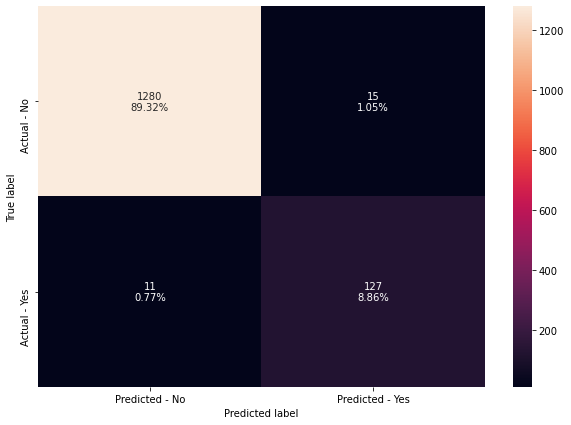

In [330]:
confusion_matrix(dtree, X_test, y_test)

Looking at the values in our performance function and then corroborating results by visualizing in a confussion matrix, we can see that our model performed great. In all honesty I was quite impressed when I got these results since decision trees are known to overfit training data. It might be the case that our feature engineering added useful information and allowed the model to perform well!

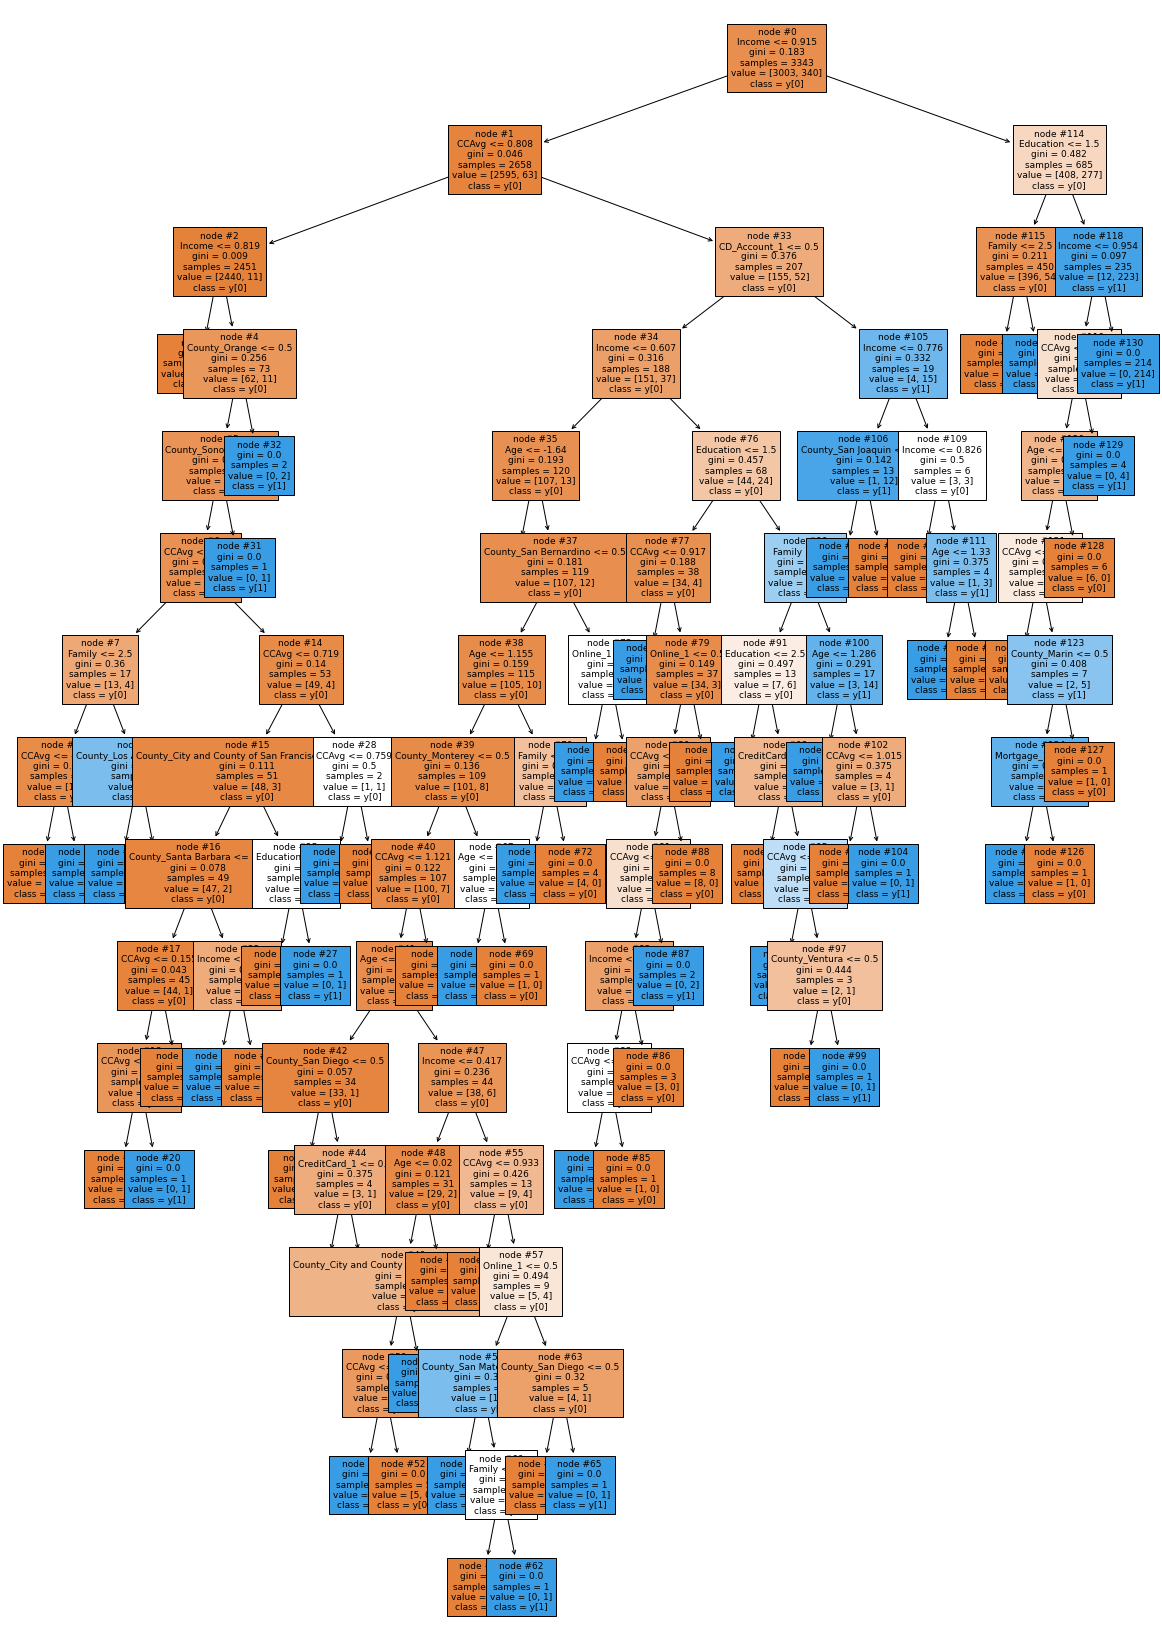

In [331]:
from sklearn import tree
plt.figure(figsize=(20,30))
tree.plot_tree(dtree,feature_names=list(X.columns),filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [332]:
print(tree.export_text(dtree,feature_names=list(X.columns),show_weights=True))

|--- Income <= 0.91
|   |--- CCAvg <= 0.81
|   |   |--- Income <= 0.82
|   |   |   |--- weights: [2378.00, 0.00] class: 0
|   |   |--- Income >  0.82
|   |   |   |--- County_Orange <= 0.50
|   |   |   |   |--- County_Sonoma <= 0.50
|   |   |   |   |   |--- CCAvg <= -0.25
|   |   |   |   |   |   |--- Family <= 2.50
|   |   |   |   |   |   |   |--- CCAvg <= -0.35
|   |   |   |   |   |   |   |   |--- weights: [12.00, 0.00] class: 0
|   |   |   |   |   |   |   |--- CCAvg >  -0.35
|   |   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |   |--- Family >  2.50
|   |   |   |   |   |   |   |--- County_Los Angeles <= 0.50
|   |   |   |   |   |   |   |   |--- weights: [0.00, 3.00] class: 1
|   |   |   |   |   |   |   |--- County_Los Angeles >  0.50
|   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |   |   |--- CCAvg >  -0.25
|   |   |   |   |   |   |--- CCAvg <= 0.72
|   |   |   |   |   |   |   |--- County_City and County of San Franc

- What this image tells us is that our model is extremely complex. We are not able to study the relationship between varibales are their effect of which decision is taken since there are too many nodes. This is true for both image and the text form. What we can see, however, is that county plays an important role in various nodes in deciding the tree's final answer. This tells us converting zip codes to county was a good idea!
- Let's perform some trimming to simplify our model by tuning some hyperparameters!

In [333]:
# Let's look at the importance of each independent variable and compare it to the previous answer provided by the logistic
# regression model
print (pd.DataFrame(dtree.feature_importances_, columns = ["Imp"], 
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                              Imp
Education                                0.369963
Income                                   0.302706
Family                                   0.169289
CCAvg                                    0.076588
CD_Account_1                             0.019846
Age                                      0.018403
Online_1                                 0.006643
CreditCard_1                             0.005402
County_Orange                            0.004857
County_San Diego                         0.003342
County_City and County of San Francisco  0.003275
County_San Joaquin                       0.003022
Mortgage_1                               0.002728
County_Sonoma                            0.002532
County_Los Angeles                       0.002456
County_Ventura                           0.002183
County_San Bernardino                    0.002159
County_Marin                             0.001949
County_Monterey                          0.001214


Very interesting, the decision tree model we built places similar weights but not exactly equal to those of logistic regression. For example, the most important feature for the tree model is Education, while for the logistic model was income, followed by security account. Here CD_Account is actually 6th on the the list, sorted by descending importance. Notice too, that many features have a weight of zero, similar to what we saw with logistic regression, since we chose lasso regularization.

In [334]:
# The first method to avoid over fiting that we will try is a pre-pruning method, we will grid search among several
# tree depths and criterion enthropy or gini. Note that pre-pruning is much more less resource intensive than post-pruning 
# and that is the reason we implement it over post-pruning.
crit = ['gini', 'entropy'] # we test both criterion and choose the best one
max_depth = [2,4,6,8,10,12] # we test depths of 2 to 12 nodes by 2

parameters = {'max_depth': max_depth, 
              'criterion': crit,
              'min_samples_leaf': np.arange(1, 20), # the minimum number of samples a leaf has to have for it to split
              'max_leaf_nodes' : [2, 3, 5, 10], # maximum number of leaf nodes (terminal nodes)
              'min_impurity_decrease': [0.001,0.01,0.1] #min impurity required for a split
             }
acc_scorer = metrics.make_scorer(metrics.recall_score) # Like we mentioned before, the bank is interested in gettong the 
# max number of customers to accept and would rather minimize FN than FP, so we choose recall as metric

dec_tree = tree.DecisionTreeClassifier() # Inititilize tree

clf_GS = GridSearchCV(dec_tree, parameters, scoring=acc_scorer, cv=5) # Grid search with 5-fold cross validation
clf_GS.fit(X_train, y_train) # fit to training data

best_parameters = clf_GS.best_estimator_ # select model with best parameters

In [335]:
best_parameters.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, min_samples_leaf=10)

We can see that the mdoel that performed best has a max depth of 6, 10 max leaf nodes, min impurity threshold of .001 and 11 minimum samples per leaf

In [336]:
metrics_func(best_parameters, X_train, X_test, y_train, y_test)

Accuracy on training set :  0.9847442416990727
Accuracy on test set :  0.988834612700628
Recall on training set :  0.8911764705882353
Recall on test set :  0.9202898550724637
Precision on training set :  0.9558359621451105
Precision on test set :  0.9621212121212122


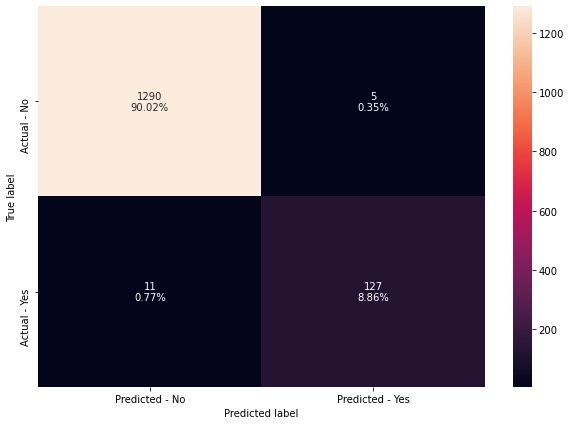

In [337]:
confusion_matrix(best_parameters, X_test, y_test)

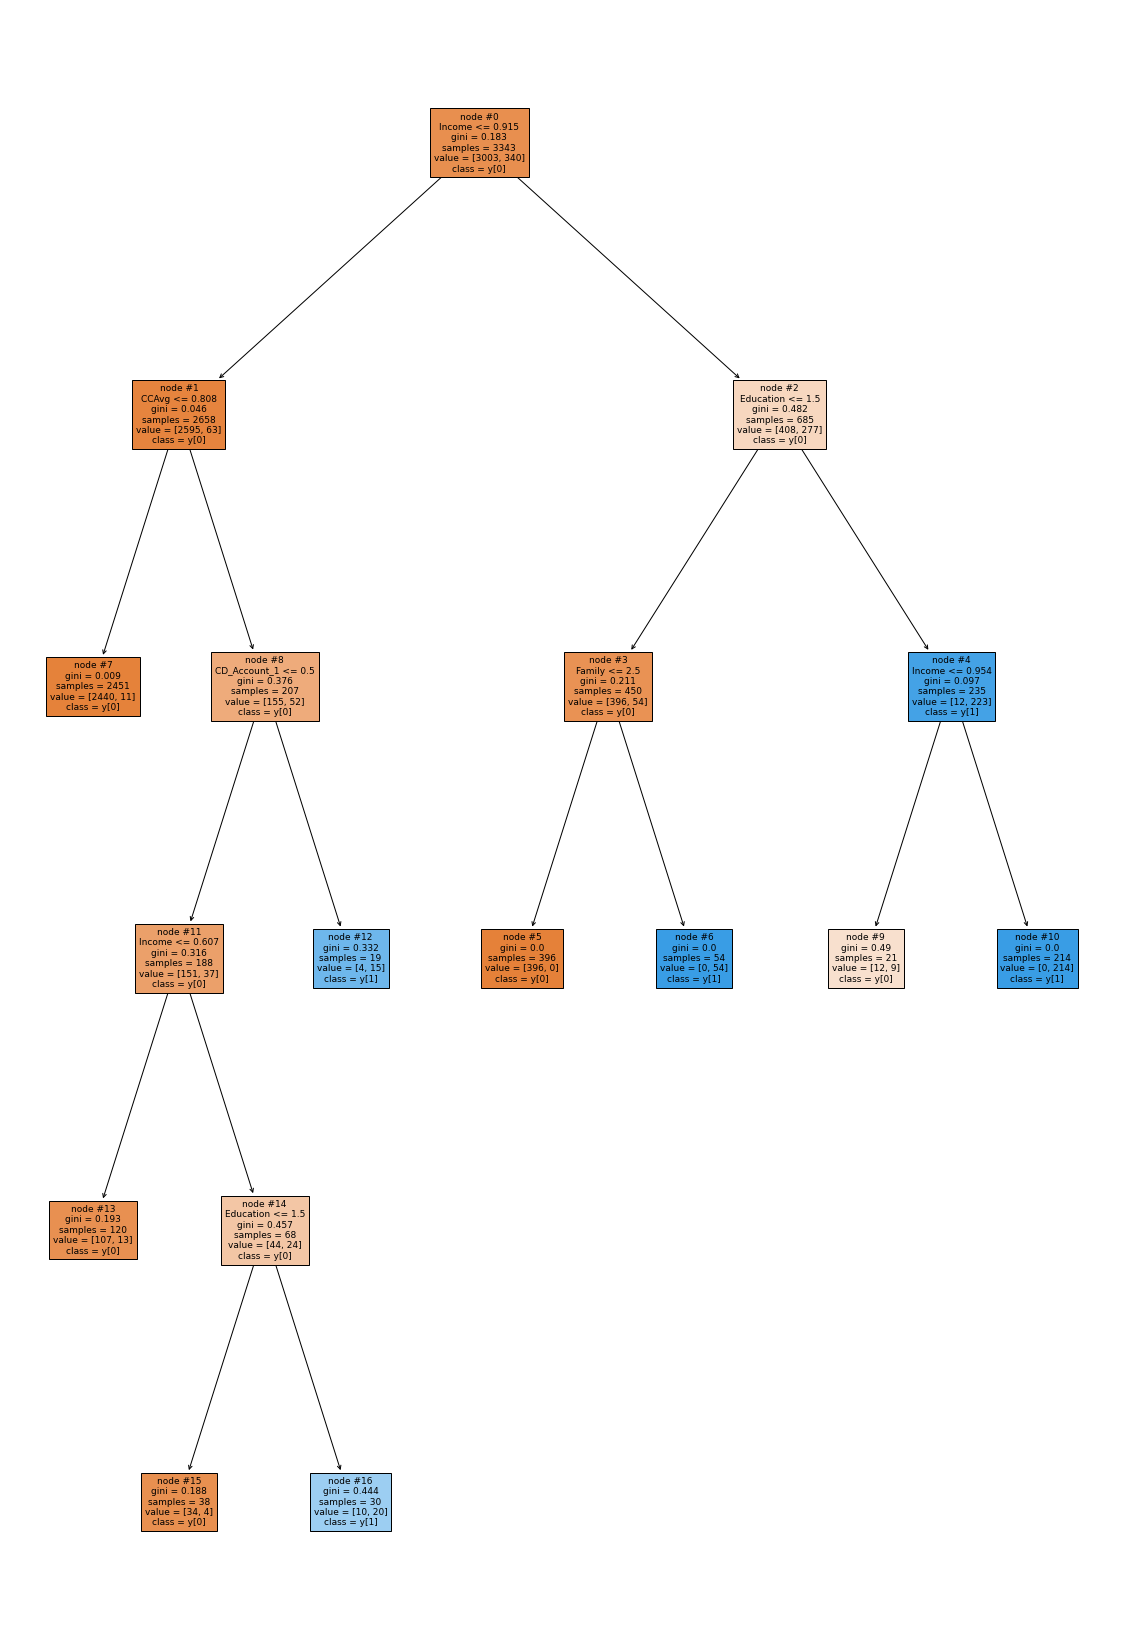

In [338]:
plt.figure(figsize=(20,30))
tree.plot_tree(best_parameters,feature_names=list(X.columns),filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [339]:
print(tree.export_text(best_parameters,feature_names=list(X.columns),show_weights=True))

|--- Income <= 0.91
|   |--- CCAvg <= 0.81
|   |   |--- weights: [2440.00, 11.00] class: 0
|   |--- CCAvg >  0.81
|   |   |--- CD_Account_1 <= 0.50
|   |   |   |--- Income <= 0.61
|   |   |   |   |--- weights: [107.00, 13.00] class: 0
|   |   |   |--- Income >  0.61
|   |   |   |   |--- Education <= 1.50
|   |   |   |   |   |--- weights: [34.00, 4.00] class: 0
|   |   |   |   |--- Education >  1.50
|   |   |   |   |   |--- weights: [10.00, 20.00] class: 1
|   |   |--- CD_Account_1 >  0.50
|   |   |   |--- weights: [4.00, 15.00] class: 1
|--- Income >  0.91
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [396.00, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [0.00, 54.00] class: 1
|   |--- Education >  1.50
|   |   |--- Income <= 0.95
|   |   |   |--- weights: [12.00, 9.00] class: 0
|   |   |--- Income >  0.95
|   |   |   |--- weights: [0.00, 214.00] class: 1



Notice that our model had mistakenly classified 11 examples as No when in reality they did accept the loan. Compared to our initial model which made a mistake in 10 of the examples. However, it was able to decrease the number of FP from 15 to 5. While the recall stayed at around the same level, 92 per cent, it is clear this new model is much simpler. That means it will perform much faster prediction on new data compared to our vanilla model, and will tend to not overfit the training dataset.

# Comparing our models
- Let's focus on the most striking difference between our logistic regression model and our decision tree. The tree was able to achieve 100 per cent accucracy without any tuning. Furthermore, usually this would be a sign of over-fitting, since the tree grows until all leaf nodes are fully homogenous, however, such was not the case with this particular dataset. Both testing and training set showed similar performance metrics. It is important to highlight the fact that this does not usually happen with real world data, and that is the reason we did pre-trimming to show proof of concept.
- The second most important characteristic that caught my attention is training time. It is true our logit model didn't perform as well, however, when compared to the tree model which we did CVGridSearch on, it took a fraction of the time to train. When working with a limited amount of computing resources, we might be unable to use a GridSearch because of the time it takes to find the top hyperparameters. However, this can be fixed by using random grid search, which has been proved to perform almost as well as an exhaustive GS. Again, this all depends on the type of problem we are looking to solve, and the resources available to us.
- For our purposes, measuring Recall was the most important metric. Even after optimizing the logistic regression model's threshold, we were not able to achieve the same peformance as our tree. On testing sets we had a Recall of .83 vs .92 on the decision tree. More importantly, the tree classifier was also able to keep a high precison of .96 vs logit's .75
- Interestingly enough, both models had a pretty high accuracy, high enough that they did better than just randomly selecting the most common class, which in turn means that theretically, we could deploy these models in the real world.

# Misclassification analysis
 Let us now see where our models failed to classify examples correctly and see if we can find any useful patterns.

In [340]:
# We will create two data sets, one with misclassifications from our logistic model, and one with the errors from our 
# decision tree
logpred = logr.predict(X_test)
X_truelog = X_test.copy()
X_truelog['Predictions'] = logpred
X_truelog['True_Val'] = y_test
misclass_log = X_truelog[X_truelog['Predictions'] != X_truelog['True_Val']]
treepred = best_parameters.predict(X_test)
X_truetree = X_test.copy()
X_truetree['Predictions'] = treepred
X_truetree['True_Val'] = y_test
misclass_tree = X_truetree[X_truetree['Predictions'] != X_truetree['True_Val']]
#Let us look at the misclassified examples by out logistic regression model first
misclass_log

,Age,Income,Family,CCAvg,Education,Mortgage_1,Securities_Account_1,CD_Account_1,Online_1,CreditCard_1,County_Butte,County_City and County of San Francisco,County_Contra Costa,County_El Dorado,County_Fresno,County_Humboldt,County_Imperial,County_Kern,County_Lake,County_Los Angeles,County_Marin,County_Mendocino,County_Merced,County_Monterey,County_Napa,County_Orange,County_Placer,County_Riverside,County_Sacramento,County_San Benito,County_San Bernardino,County_San Diego,County_San Joaquin,County_San Luis Obispo,County_San Mateo,County_Santa Barbara,County_Santa Clara,County_Santa Cruz,County_Shasta,County_Siskiyou,County_Solano,County_Sonoma,County_Stanislaus,County_Trinity,County_Tuolumne,County_Ventura,County_Yolo,Predictions,True_Val
3141,1.023879,1.130375,3,-0.979385,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2536,0.499899,0.783575,1,1.204447,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4575,0.674559,0.934644,2,-1.183999,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3343,1.460530,1.059930,1,-0.406102,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2691,1.373200,0.986019,2,1.486490,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3478,-1.246703,1.153142,1,0.048939,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
293,-0.024082,0.615602,4,0.666238,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1328,1.285870,1.282940,4,1.761583,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3084,-1.683353,1.107259,3,-0.806387,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1176,-1.421363,0.769058,4,0.967302,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [341]:
# While doing our misclassification analysis it is a good idea to focus on independent variables that have a large lof odds 
# coefficent since those are the most likely to affect out model!
print(misclass_log['Predictions'].value_counts()) # Most mistakes were made in classifying people who accepted the loan as
# people who didn't. Of course, we know this from the confusion matrix!
print(misclass_log.groupby('Predictions')['Securities_Account_1'].value_counts())
pd.DataFrame(misclass_log.groupby('Predictions').mean())[[ 'Age','Income', 'CCAvg']]

0    44
1     9
Name: Predictions, dtype: int64
Predictions  Securities_Account_1
0            0                       41
             1                        3
1            0                        9
Name: Securities_Account_1, dtype: int64


,Age,Income,CCAvg
Predictions,,,
0,-0.067747,0.940582,0.676172
1,-0.189038,1.156153,0.999279


In [342]:
print(X_truelog.groupby('True_Val')['Securities_Account_1'].value_counts())
pd.DataFrame(X_truelog.groupby('True_Val').mean())[[ 'Age','Income', 'CCAvg']]

True_Val  Securities_Account_1
0         0                       1149
          1                        146
1         0                        123
          1                         15
Name: Securities_Account_1, dtype: int64


,Age,Income,CCAvg
True_Val,,,
0,-0.017271,-0.149209,-0.119341
1,-0.074708,1.281994,0.911873


Aha! From the log odds table we showed at stage of logit model implementation, we know that having a securities account is highly associated with having accepted the loan, however, note that when grouping by predictions, most of the the errors where the model predicted not accepting the loan, have individuals without a securities account (41 out of 44 in fact). This could have affected our model performance. Avergae income in our misclassified examples also seems to be lower than in the grouped set by true values. These effects compounded, made it difficult for our model to make the correct prediction in those instances!

Let's now look at the mistakes made by the decision tree model!

In [343]:
misclass_tree

,Age,Income,Family,CCAvg,Education,Mortgage_1,Securities_Account_1,CD_Account_1,Online_1,CreditCard_1,County_Butte,County_City and County of San Francisco,County_Contra Costa,County_El Dorado,County_Fresno,County_Humboldt,County_Imperial,County_Kern,County_Lake,County_Los Angeles,County_Marin,County_Mendocino,County_Merced,County_Monterey,County_Napa,County_Orange,County_Placer,County_Riverside,County_Sacramento,County_San Benito,County_San Bernardino,County_San Diego,County_San Joaquin,County_San Luis Obispo,County_San Mateo,County_Santa Barbara,County_Santa Clara,County_Santa Cruz,County_Shasta,County_Siskiyou,County_Solano,County_Sonoma,County_Stanislaus,County_Trinity,County_Tuolumne,County_Ventura,County_Yolo,Predictions,True_Val
4575,0.674559,0.934644,2,-1.183999,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1176,-1.421363,0.769058,4,0.967302,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1028,-1.421363,0.867853,4,0.622222,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1577,-0.984713,0.077367,1,0.826835,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
505,-0.810052,0.167099,3,0.863634,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
402,0.761889,0.615602,1,1.377446,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4583,0.587229,0.444673,1,0.863634,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2738,-0.897382,0.769058,2,1.281876,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3145,-0.984713,0.921521,3,0.933799,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2470,-1.072043,0.408023,2,1.281876,3,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [344]:
# Only 16 incorrect classification, but again, we already new this from the confusion matrix
print(misclass_tree['Predictions'].value_counts())

0    11
1     5
Name: Predictions, dtype: int64


In [345]:
pd.DataFrame(misclass_log.groupby('Predictions').mean())[[ 'Age','Income', 'CCAvg']]

,Age,Income,CCAvg
Predictions,,,
0,-0.067747,0.940582,0.676172
1,-0.189038,1.156153,0.999279


In [346]:
pd.DataFrame(X_truelog.groupby('True_Val').mean())[[ 'Age','Income', 'CCAvg']]

,Age,Income,CCAvg
True_Val,,,
0,-0.017271,-0.149209,-0.119341
1,-0.074708,1.281994,0.911873


Notice how average income also differs by a very large percentage between the true values and our prediction. Those individuals predicted to not accept (but did accept in reality) have and avergae income of .94, remember we have done a standarization on these values. In the real group the average is -.15. What's even more interesting is that all of our misclassified values do not have a securities account, which provides further substance to our theory that these factors greatly affect the performance of our models. Of course, decision trees can handle these particularities much better than logistic regression because of how they split the data into nodes to approximate the true probability distribution of the system, while logistic regression uses best fit method, and many assumptions have to be made beforehand.

# Conclusion and Actionable insights For Marketing team

- Firstly drawing from the insight above of comparison between models, if the team has enough computational power and time, they should go for the pre-pruned tree model since it performs much better than the logistic regression one.
- Looking at the coefficients from both of our models, Income and Education are key in predicting whether or not a client will accept the loan. The team should focus their efforts in clients with incomes above the mean (according to the information gathered from our pairplot with hue). That would be income above 73, 000 dollars per year.
- Education is also an important predictor in both models. So again, focus on individuals with either a master's or professional degree. This means marketing campaigns geared towards enterprises or research centers, perhaps!
- In marketing, it is very important to know the age of your customers as this allows you to create campaigns that resonate with their ineterests. Since we noted age is similar for those that accepted the loan and those that didn't (with a similar distribution as well), campaigns that cater to the general public should be chosen over campaign that target niche interests in order to capture as large a population as possible.
- Finally, the bank should go through its database and look at the individuals who have a Certificate of Deposit account and send loan offers since this variable shows great importance in both of our models! Since most counties have a relatively low importance in our models, the campaign can safely be implemented in as many counties as budget allows. Starting with Orange County, San Diego, Los Angeles and moving down while considering the importance our model has given them.